# MARKOV CHAIN MONTE CARLO: THEORY

# 1. Introduction

## 1.1 Challenges in Bayesian inference

In the previous session we saw a sample of distances to stars from a volume-limited survey, and a model describing their distribution. We constructed the posterior of the model parameter $\alpha$ (power law index) and by maximizing it we estimated the value of $\alpha$.

Our approach was simple because the model had just one parameter. Also, we didn't try to estimate the uncertainty on $\alpha$.

In this session we will see a general method of that can be applied to simple and complex models, able to naturally provide uncertainties.

### Challenge 1: multiple parameters $\equiv$ multiple dimensions

If our model has many parameters, $\theta_1, \theta_2, \cdots, \theta_k$, then the posterior is a $k$-dimensional function.

$$ P(\theta_1, \theta_2, \cdots, \theta_k | \mathrm{Data}) $$

Finding the maximum of a $k$-D function is...way harder than in the $1$-D case!

We could try to compute the posterior in a $k$-dimensional **grid** and select the point with the highest posterior. Though, a complex function might have narrow peaks - a high resolution grid might be necessary. The higher the resolution and the number of dimensions, the higher number of evaluations of the posterior - making the computation extremely time consuming.

### Challenge 2: uncertainties

Maximizing the posterior provides an estimate of the parameter but not its uncertainty. There are approximate solutions to get an estimate of the uncertainty on the parameter, but they usually make an assumption about the shape of the posterior (e.g. Gaussian peak).

### Challenge 3: brute-force is non-optimal...

Another complication with grids is that we may spend a lot of time at regions of the parameter space where the posterior is low. Instead, we would like to spend more time around the peaks, the regions of high posterior probability.

![Mishra's Bird function](images/testfunc.png)


## 1.2 A solution through sampling

**If we could sample** from the posterior distribution $N$ points from the $k$-dimensional parameter space

$$ \Theta_1 \equiv \left(\theta_{1,1}, \theta_{2,1}, \cdots, \theta_{k,1}\right) $$
$$ \Theta_2 \equiv \left(\theta_{1,2}, \theta_{2,2}, \cdots, \theta_{k,2}\right) $$
$$ \vdots $$
$$ \Theta_N \equiv \left(\theta_{1,N}, \theta_{2,N}, \cdots, \theta_{k,N}\right) $$

then the expected value of each parameter $\theta_i$ is simply the mean value:

$$ \bar{\theta}_i = \frac{1}{N} \sum\limits_{j=1}^{N} { \theta_{i,j} } $$

In a similar way, the uncertainty is given by the formula for the sample standard deviation:

$$ \sigma_{\theta_i} = \sqrt { \frac{1}{N-1}\sum\limits_{j=1}^{N}{ \left(\theta_{i,j} - \bar{\theta}_i  \right)^2 } }$$

Almost all statistical quantities that we may need (covariances, medians, confidence intervals, etc.) can be estimated from a large sample. The bigger the sample, the better the accuracy of our estimates.

Most importantly, if someone wants to use the parameter estimates with uncertainties, they don't have to use our reported statistics. We can ship them the $N$ samples, and perform their analysis on them. E.g.:

$$ \hat{f}(\theta_1, \theta_2, \cdots, \theta_k) = \frac{1}{N} \sum\limits_{i=1}^{N} {f(\Theta_i)} $$

###  Problem: how to sample from a posterior?

# 2. The Markov Chain Monte Carlo technique

The Marcov Chain Monte Carlo (MCMC) is a widely used technique to sample from probability distributions, and therefore likelihoods or posteriors.

It is based on the idea of creating a chain of points in the parameter space, using a combination of (i) random walk and (ii) selection of points based on their relative probability.

An algorithm is used to ensure that the chain will reach **equilibrium**: after a number of steps (or legnth of the Markov chain) the chain will contain points that follow the same distribution, the **target distribution**.

> It is often characterized as one of the most influencial algorithms of the 20th century...

## 2.1 Metropolis-Hastings algorithm: application on the distance example

We will discuss the Metropolis-Hastings algorithm, but note that there are *many* others out there. Here are the steps:

1. We start with one set of parameters $\theta_1$. 

    - In our case, $\theta_1$ is simply $\alpha$ since we have only one parameter in our model.
    
    - In general, $\theta_1$ can be a vector of 1, 5, or even a million separate parameters.
    
    This first value starts our Markov chain.
      
2. Using **some method** we obtain a new trial set of parameters $\theta_2$. *A proposition for a new position...*
    
    - It is important that this set is chosen randomly, but based on the previous set.
    - The dependence on only the previous set, is an essential property of a *Markov chain*.
    - The randomness is where the *Monte Carlo* in MCMC comes from.
    - The simplest method to obtain our new parameter values will be to add some random (Gaussian?) noise to our current value: $\theta_2 = \theta_1 + \epsilon$. This is also called **step size**. You typically want to tune the step size, $\epsilon$, to optimize the process for a given problem.
    
3. Now, we want to calculate and compare the posterior probabilities for both $\theta_1$ and $\theta_2$. If the new parameter is better than the current one,

    $$ P(\theta_2) > P(\theta_1) $$
    we always move the chain to $\theta_2$. If not, we *might* move to $\theta_2$ with probability equal to the ratio
    $$ \frac{P(\theta_2)}{P(\theta_1)}$$
    In practice, we draw a random number from a uniform distribution between 0 and 1. If that random number is less than the ratio, we move the chain to $\theta_2$. Else, we stay at $\theta_1$ for another iteration.

4. Now that we have our new value for $\theta$, we return to step 2 and repeat for as many iterations as we want. Often this is in the thousands or more.

![Metropolis-Hastings algorithm creating a Markov Chain. From [2]](images/mh.png)

## 2.2 Let's implement the M-H algorithm...

In [1]:
def metro_hastings(ln_posterior, theta_0, N_steps, step_size=0.2, args=[]):
    """Metropolis-Hastings algorith for sampling the posterior distribution.

    Parameters
    ----------
    ln_posterior : function that returns the logarithm of the posterior
    theta_0      : initial guess for the model parameter
    N_steps      : the length of the Markov Chain that will be returned
    step_size    : the standard deviation of the normally distributed step size
    args         : additional arguments to be passed to the posterior function
    
    Returns
    -------
    A numpy array containing the Markov Chain.
    
    """
    chain = np.zeros(N_steps)                     # create the chain
    chain[0] = theta_0                            # store the initial point...
    print("{:.3f}".format(chain[0]), end=",")     # ...and print it!
    
    # hold the current value of the posterior to avoid recomputing it if position is not changed
    curr_P = ln_posterior(theta_0, *args)
    
    # populate the rest of the point in the chain
    for i in range(N_steps - 1):
        new_theta = chain[i] + np.random.normal(scale=step_size)
        new_P = ln_posterior(new_theta, *args)
        
        # should we move to the new position?
        if (new_P > curr_P) or (np.random.rand() < np.exp(new_P - curr_P)):
            # if yes... store the new value, print it and update the 'current posterior'
            chain[i + 1] = new_theta
            print("{:.3f}".format(chain[i + 1]), end=",")
            curr_P = new_P
        else:
            # if no... store again the current position and print a '.'
            chain[i + 1] = chain[i]
            print(".", end=", ")
            
    return chain

## 2.3 Make the data for this example
Now, let's create the data like we did in the previous section, for 1000 stars and run the algorithm for 200 steps.

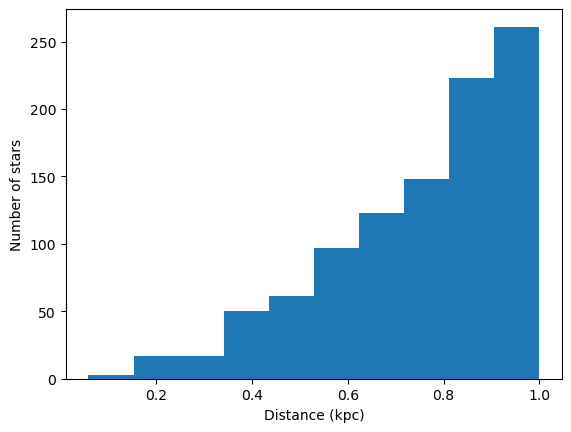

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

# Let's make the data for the distance example

N_stars = 1000
dist_max = 1.0 # in kpc
dist = np.random.uniform(size=N_stars)**(1.0/3.0) * dist_max
dist_err = 0.1 * np.ones(len(dist))
dist_obs = dist + np.random.normal(size=N_stars, scale=dist_err)
plt.figure()
plt.hist(dist)
plt.xlabel("Distance (kpc)")
plt.ylabel("Number of stars")
plt.show()

## 2.4 Defining the posterior for our problem

In [3]:
def func_pdf(alpha, x_max, x):
    """The probability density function at 'x' given the parameters 'alpha' and 'x_max'."""
    P_x = (alpha + 1.0) * x ** alpha / x_max ** (alpha + 1.0)
    
    if isinstance(x, np.ndarray):
        P_x[x > x_max] = 0.0 
        P_x[x < 0.0] = 0.0
    elif (x > x_max) or (x < 0.0):
        P_x = 0.0
    
    return P_x

def ln_prior(alpha):
    """The log-prior on 'alpha'."""
    if alpha <= 0.0:
        return -np.inf
    return 0.0

def ln_likelihood(alpha, x_max, x_obs, x_err):
    """The log-likelihood given the data (x_obs, x_err) and the model parameter."""
    result = 0.0
    for i in range(len(x_obs)):
        a, b = (0.0 - x_obs[i]) / x_err[i], (x_max - x_obs[i]) / x_err[i]
        ran_x = st.truncnorm.rvs(a, b, loc=x_obs[i], scale=x_err[i], size=1000)
        ran_y = func_pdf(alpha, x_max, ran_x)
        result += np.log(np.mean(ran_y))
    return result

def ln_posterior(alpha, x_max, x_obs, x_err):
    """The log-posterior given the data (x_obs, x_err) and the model parameter."""
    return ln_prior(alpha) + ln_likelihood(alpha, x_max, x_obs, x_err)

## 2.5 Running the M-H algorithm

In [4]:
alpha_0 = 3.0
step_size = 0.3


start = time.time()
chain = metro_hastings(ln_posterior, alpha_0, args=(dist_max, dist_obs, dist_err), 
                       step_size=step_size, N_steps=200)
end = time.time()

print()
print("Elapsed time:", end-start, "seconds")

3.000,., 2.912,2.748,., ., ., 2.652,2.613,., ., ., 2.407,1.938,., 2.165,., ., 2.235,2.093,1.864,1.877,., 1.971,2.030,2.138,2.270,2.117,., 2.016,., ., ., ., 2.194,2.139,., ., ., ., ., 1.958,2.141,., 2.032,2.026,., ., ., ., ., ., ., 2.023,2.131,., ., 2.019,., 1.994,2.060,., ., ., ., ., ., 1.879,1.993,., 2.099,2.186,., 2.188,., 2.065,., ., 2.161,., 2.146,., 1.967,2.261,2.143,., ., ., ., ., 2.136,., 2.283,2.249,1.842,2.162,2.186,., ., ., 2.340,., 2.288,2.247,., 2.124,1.917,1.907,2.126,., 2.215,., ., ., ., 2.103,., ., ., 2.011,., 1.938,., ., 2.026,2.151,2.171,., 2.110,., ., ., ., ., ., ., ., ., ., ., ., ., ., 2.057,2.006,., ., ., 1.968,1.928,., 2.097,1.925,1.908,1.828,., 1.988,1.975,., ., ., 2.041,2.032,., ., 1.958,2.231,2.026,., 2.036,., ., ., ., ., ., ., ., ., ., 2.124,., ., 2.137,., 2.137,., 2.221,., 2.116,., ., 1.972,1.974,1.960,., ., ., 2.110,., 
Elapsed time: 54.59984636306763 seconds


## 2.6 The produced Markov Chain and the *burn-in* phase

The first steps in the chain are not in the optimal regime. This is called the "burn-in" and is thrown away. In principle, there is no absolute way to determine if your chains have converged to the optimal region of parameter space. In practice, unless your problem is pathological, it is usually pretty obvious. Do remember this can be an issue and take care!

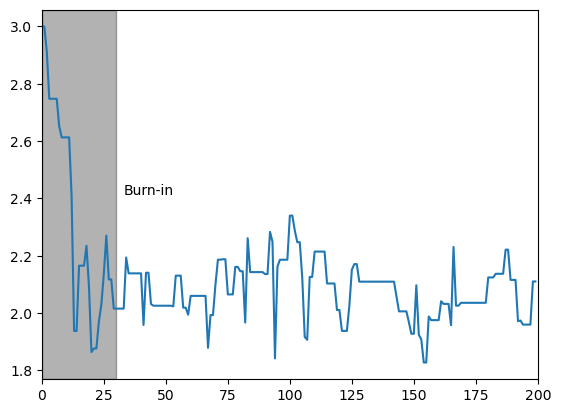

In [5]:
n_burnin = 30   # change this value if needed

plt.figure()
plt.axvspan(0, n_burnin, color="k", alpha=0.3)
plt.plot(chain)
_, _, y_min, y_max = plt.axis()
plt.text(n_burnin + 3, (y_min + y_max) / 2.0, "Burn-in")
chain_converged = chain[n_burnin:]
plt.xlim(0,len(chain))
plt.show()

## 2.7 The acceptance fraction

The acceptance fraction depends on the target distribution. It has been shown that for one-dimensional Gaussian distributions, the optimal acceptance fraction is 50%, while for high dimensional Gaussian distributions is 23.4%.

Very small or large acceptance fraction indicates that the step size is not appropriate and the algorithm struggles to reach to the target distribution. By tuning the step size, $\epsilon$, we can optimize the procedure.

In [6]:
N_accepted = np.sum(chain_converged[:-1] != chain_converged[1:])
print("Acceptance fraction: {:.3f}".format(N_accepted/len(chain_converged)))

Acceptance fraction: 0.400


Our acceptance fraction might be low or high. We can adapt this by increasing/decreasing $\epsilon$. This might affect the length of the burn-in phase.

## 2.8 Reporting results in the $m \pm s$ form or with confidence intervals

Now, we can plot the posterior distribution of $\alpha$ to obtain our final result.

  mean +/- std |  2.080 +/- 0.095
median +hi -lo |  2.103 +0.059 -0.115


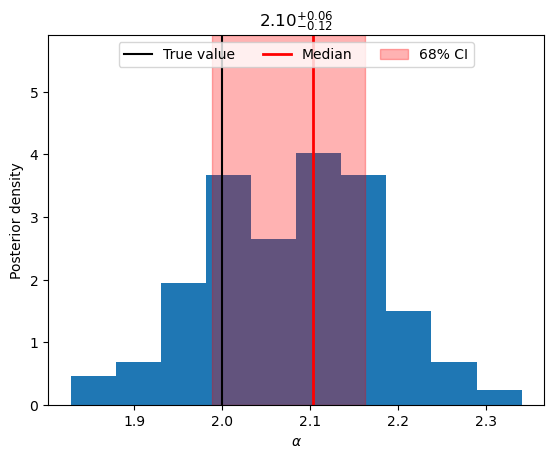

In [7]:
mean, std = np.mean(chain_converged), np.std(chain_converged)
lo68, median, hi68 = np.percentile(chain_converged, [16, 50, 84])

print("  mean +/- std |  {:.3f} +/- {:.3f}".format(mean, std))
print("median +hi -lo |  {:.3f} +{:.3f} -{:.3f}".format(
    median, hi68 - median, median - lo68))


plt.figure()
plt.hist(chain_converged, bins=10, density=True)
_, _, _, y_max = plt.axis()
plt.ylim(ymax=y_max*1.4)

plt.axvline(2.0, color="k", label="True value")
plt.axvline(median, color="r", linewidth=2, label="Median")
plt.axvspan(lo68, hi68, color="r", alpha=0.3, label="68% CI")
plt.title(r"${:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$".format(median, hi68 - median, median - lo68))
plt.xlabel(r"$\alpha$")
plt.ylabel("Posterior density")
plt.legend(loc="upper center", ncol=3)
plt.show()

# 3. The MCMC Hammer... `emcee`:
## ...a *seriously kick-ass MCMC*...

> official statement in an older version of the documentation: https://emcee.readthedocs.io/en/v2.2.1/

There are various MCMC algorithms (or samplers) out there. One very good algorithm that does not require much tuning is Goodman & Weare’s Affine Invariant Markov chain Monte Carlo Ensemble Sampler [3], with a Python implementation: the `emcee` module.

## Multiple walkers (ensemble)

A walker might fail due to an "unfrotunate" initial position. By having many of them we might explore the parameter space more efficiently and with less risk. Typical choices: 100 or 1000. `emcee` does this for us.

## Implementation of the *stretch* move

We will see that in the example

## Parallelization

`emcee` supports parallel computing, and therefore we can exploit the full potential of our machines or computer clusters. This is useful for large datasets, or complex likelihood functions (e.g., Kouroumpatzakis et al. 2020 [4]). 

# 4. Using `emcee` to fit a linear model

Suppose we want to fit a linear model

$$ y = a x + b $$

using some measured values $(x_i, y_i)$.

## 4.1 The data...

Let's make artificial data. The $x$-values are taken randomly in the range (10, 30), the uncertainty on the $y$ measurements is a random number in the range (0.2, 1.0). We produce the artificial $y$-values by applying the model on $x$ and adding the noise.

The true values of $a$ and $b$ are $0.4$ and $1.1$ respectively.

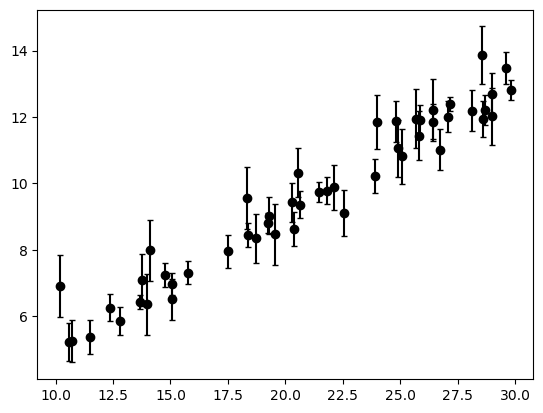

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

x_min = 10.0
x_max = 30.0
a_true = 0.4
b_true = 1.1
n_points = 50
min_noise = 0.2
max_noise = 1.0

x_obs = np.random.uniform(x_min, x_max, size=n_points)
y_err = np.random.uniform(min_noise, max_noise, size=n_points)
y_obs = a_true * x_obs + b_true + np.random.normal(scale=y_err)

plt.figure()
plt.errorbar(x_obs, y_obs, yerr=y_err, fmt="ko", capsize=2)
plt.show()

## 4.2 The prior / likelihood / posterior

In [9]:
def my_prior(theta):
    # Uncomment the next three lines if you want to constrain the parameters
    #a, b = theta
    #if a < 0.0 or a > 10.0 or b < 0.0 or b > 10.0:
    #    return -np.inf
    return 0.0

def my_likelihood(theta):
    a, b = theta
    return -np.sum((y_obs - a * x_obs - b) ** 2.0 / (2 * y_err ** 2.0))

def my_posterior(theta):
    return my_prior(theta) + my_likelihood(theta)

## 4.3 Setting the `emcee` sampler

In [10]:
import emcee

n_walkers = 100
n_dim = 2
n_steps = 2000

# set the parameter
a0 = np.random.uniform(0.0, 3.0, size=n_walkers)
b0 = np.random.uniform(0.0, 3.0, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
p0 = np.array([a0, b0]).T

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=my_posterior, 
                                moves=emcee.moves.GaussianMove(0.3)
                               )

## 4.4 Sampling from the posterior

In [11]:
result = sampler.run_mcmc(p0, nsteps=n_steps)

Let's inspect the output. There are three dimenions:

$$\large 
    \left(\text{# of walkers}\right) \times 
    \left(\text{# of steps}\right) \times
    \left(\text{# of dimensions}\right)
$$

In [12]:
print(sampler.chain.shape)

(100, 2000, 2)


## 4.5 Inspecting the chains

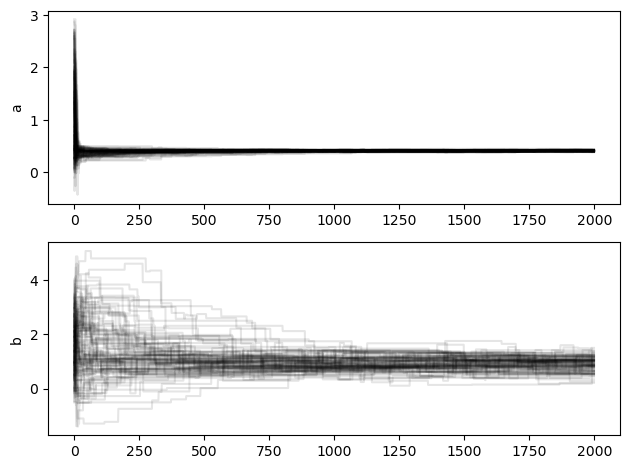

In [13]:
plt.figure()

for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel("a" if param_i == 0 else "b")
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

## 4.6 Removing the burn-in phase

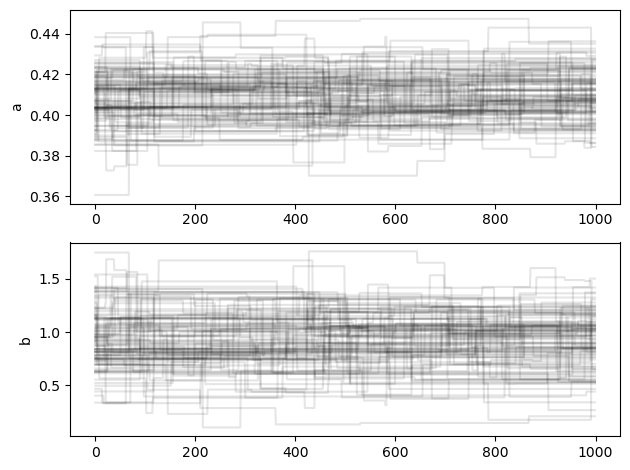

In [14]:
n_burnin = 1000

plt.figure()
for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel("a" if param_i == 0 else "b")
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

## 4.7 Corner plot of all the samples from the converged chains

Converged chain shape     : (100, 1000, 2)
Converged flatchain shape : (100000, 2)


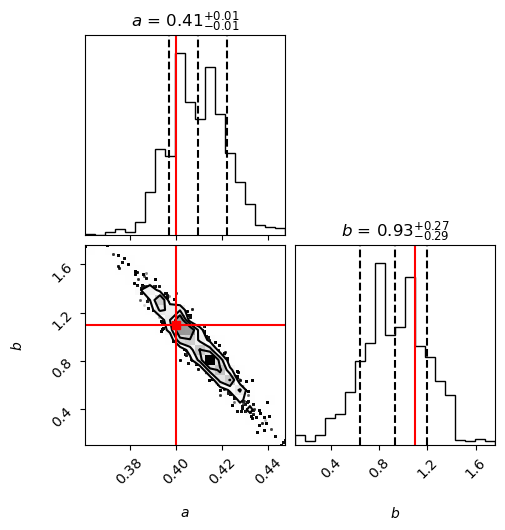

In [15]:
converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape     :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flatchain shape :", flat_converged_chain.shape)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a_true, b_true],
                    truth_color="r",
                    labels=[r"$a$", r"$b$"],
                    show_titles=True
                   )

# 5. The stretch move of `emcee`

When we have multiple walkers, we can exploit their distribution in the parameter space to explore it at an optimal scale. Essentially, a move from a walker at position $X_j$ can be at the direction of another walker $X_k$, with a step equal to the distance of the walkers times a factor that is randomly sampled in the range $(1/Z, Z)$ where $Z$ is the *stretch factor* which is by default $2.0$ in `emcee`. The theroy behind this move, including its compatibility with the Metropolis-Hastings algorithm can be found in  Goodman & Weare 2010 (https://msp.org/camcos/2010/5-1/p04.xhtml).

![title](images/stretch_move.png)

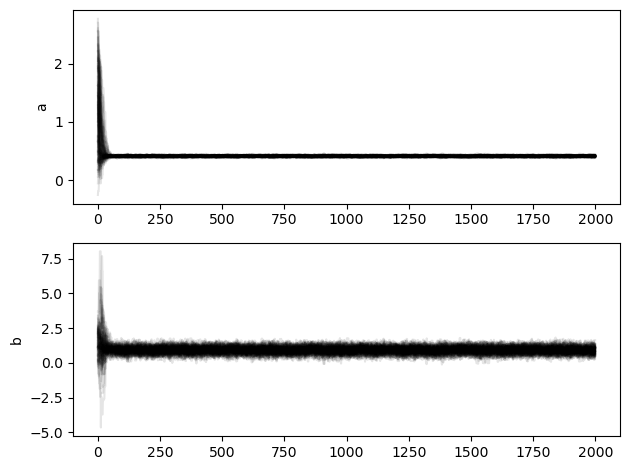

In [16]:
import emcee

n_walkers = 100
n_dim = 2
n_steps = 2000

# set the parameter
a0 = np.random.uniform(0.0, 3.0, size=n_walkers)
b0 = np.random.uniform(0.0, 3.0, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
p0 = np.array([a0, b0]).T

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=my_posterior, 
                                # moves=emcee.moves.GaussianMove(0.3)
                                # WE COMMENTED THIS OUT TO USE THE DEFAULT STRETCH MOVE
                               )

result = sampler.run_mcmc(p0, nsteps=n_steps)

plt.figure()
for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel("a" if param_i == 0 else "b")
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

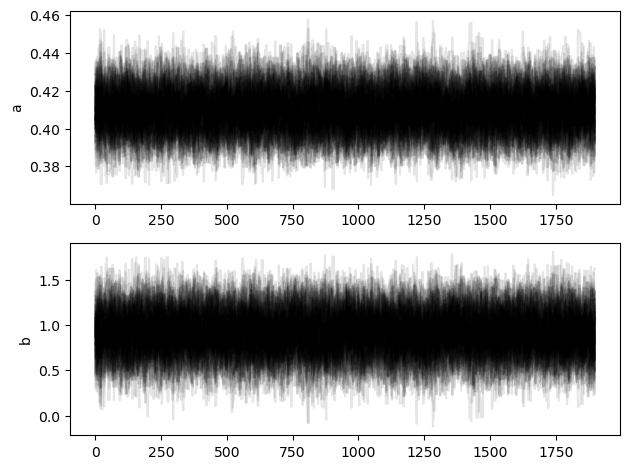

Converged chain shape     : (100, 1900, 2)
Converged flatchain shape : (190000, 2)


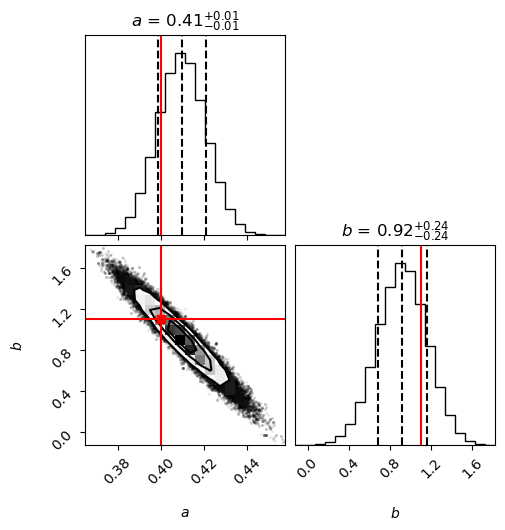

In [17]:
n_burnin = 100

plt.figure()
for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel("a" if param_i == 0 else "b")
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape     :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flatchain shape :", flat_converged_chain.shape)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a_true, b_true],
                    truth_color="r",
                    labels=[r"$a$", r"$b$"],
                    show_titles=True
                   )

# 6. Adapting MCMC hyperparameters to a problem 

In the case of non-linear models, and with many dimensions, MCMC is harder to converge. The number of walkers, and step might need to be adapted.

### Increase the **number of walkers**... 

...to explore the parameter space faster in the beginning!

### Increase the **number of steps**...

...to get a better chance for convergence. Fortunately, with `emcee` it is possible to run more steps at will! For example, for the fitting in Kouroumpatzakis et al. 2020 (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.5967K/abstract), and the user was asked if they want to continue or stop after a given number of steps (or convergence being detected automatically).

## Let's try a more difficult model...

$$ y = (a x^2 + b x + c) e^{x/d} $$

$$c > b$$

$$d > 3$$

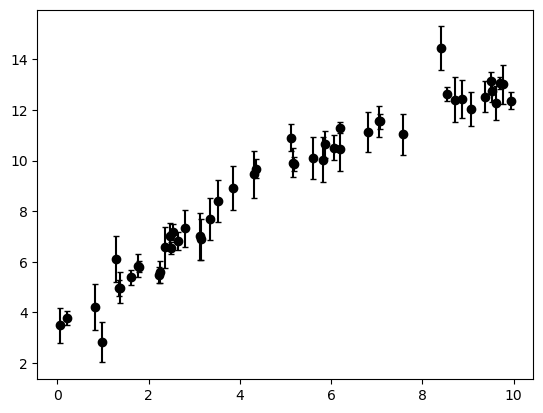

In [18]:
import numpy as np
import matplotlib.pyplot as plt

x_min = 0.0
x_max = 10.0

a_true = 0.5
b_true = 1.4
c_true = 3.4
d_true = 6.0

n_points = 50
min_noise = 0.2
max_noise = 1.0

x_obs = np.random.uniform(x_min, x_max, size=n_points)
y_err = np.random.uniform(min_noise, max_noise, size=n_points)
y_obs = (a_true * x_obs**2.0 + b_true * x_obs + c_true) * np.exp(-(x_obs/d_true)) + np.random.normal(scale=y_err)

plt.figure()
plt.errorbar(x_obs, y_obs, yerr=y_err, fmt="ko", capsize=2)
plt.show()

In [19]:
def my_prior(theta):
    # Uncomment the next three lines if you want to constrain the parameters
    a, b, c, d = theta
    if c < b or d < 3:
        return -np.inf
    return 0.0

def my_likelihood(theta):
    a, b, c, d = theta
    return -np.sum((y_obs - ((a * x_obs**2.0 + b * x_obs + c)) * np.exp(-x_obs/d)) ** 2.0 / (2 * y_err ** 2.0))

def my_posterior(theta):
    return my_prior(theta) + my_likelihood(theta)

In [20]:
n_walkers = 100
n_dim = 4
n_steps = 200

# set the parameter
a0 = np.random.uniform(0.0, 10.0, size=n_walkers)
b0 = np.random.uniform(0.0, 10.0, size=n_walkers)
c0 = np.random.uniform(0.0, 10.0, size=n_walkers)
d0 = np.random.uniform(0.0, 10.0, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
p0 = np.array([a0, b0, c0, d0]).T

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=my_posterior)

In [21]:
result = sampler.run_mcmc(p0, nsteps=n_steps)

/home/konstantinos/anaconda3/envs/astrostat22/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/tmp/ipykernel_307988/3689009388.py:10: RuntimeWarning: overflow encountered in exp
  return -np.sum((y_obs - ((a * x_obs**2.0 + b * x_obs + c)) * np.exp(-x_obs/d)) ** 2.0 / (2 * y_err ** 2.0))
/tmp/ipykernel_307988/3689009388.py:10: RuntimeWarning: overflow encountered in square
  return -np.sum((y_obs - ((a * x_obs**2.0 + b * x_obs + c)) * np.exp(-x_obs/d)) ** 2.0 / (2 * y_err ** 2.0))


In [22]:
print(sampler.chain.shape)

(100, 200, 4)


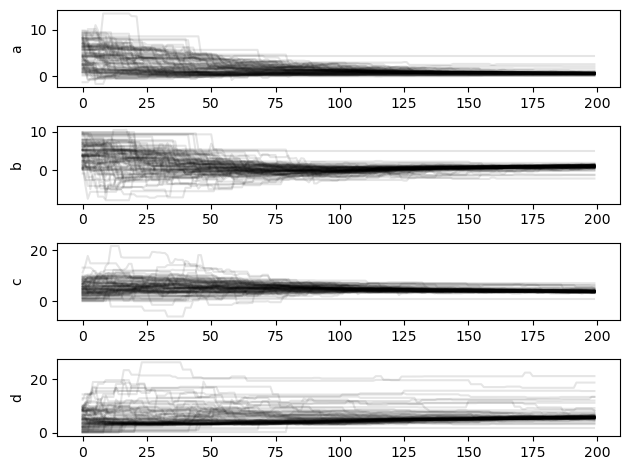

In [23]:
plt.figure()

for param_i in range(n_dim):
    plt.subplot(n_dim, 1, param_i+1)
    plt.ylabel(["a", "b", "c", "d"][param_i])
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

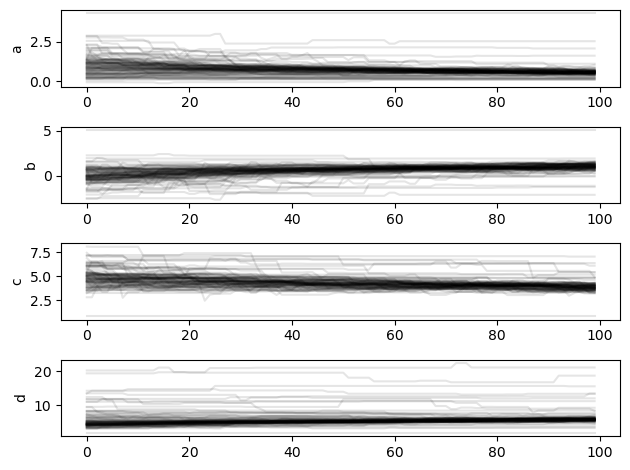

In [24]:
n_burnin = 100

plt.figure()

for param_i in range(n_dim):
    plt.subplot(n_dim, 1, param_i+1)
    plt.ylabel(["a", "b", "c", "d"][param_i])
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

Converged chain shape     : (100, 100, 4)
Converged flatchain shape : (10000, 4)


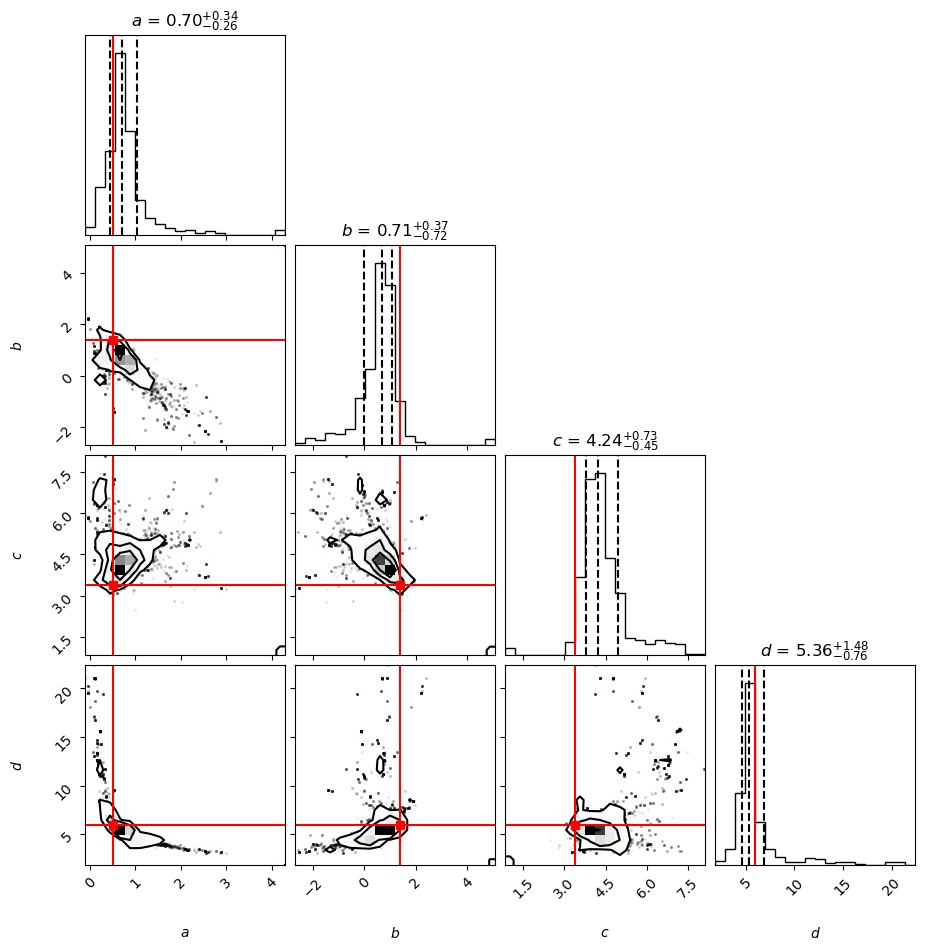

In [25]:
converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape     :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flatchain shape :", flat_converged_chain.shape)

percentage_to_include = 1.0   # change this to 0.95 to exlude extreme values

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    range=[percentage_to_include]*4,
                    truths=[a_true, b_true, c_true, d_true],
                    truth_color="r",
                    labels=[r"$a$", r"$b$", r"$c$", r"$d$"],
                    show_titles=True
                   )

![Howard](images/bigbang_markov.jpg)

## References

[1]. Wikipedia contributors. (2019, May 9). Test functions for optimization. In Wikipedia, The Free Encyclopedia. Retrieved 20:20, June 12, 2019, from https://en.wikipedia.org/w/index.php?title=Test_functions_for_optimization&oldid=896257708

[2]. Lee, Jaewook & Sung, Woosuk & Choi, Joo-Ho. (2015). Metamodel for Efficient Estimation of Capacity-Fade Uncertainty in Li-Ion Batteries for Electric Vehicles. Energies. 8. 5538-5554. 10.3390/en8065538.

[3]. Foreman-Mackey, D., Hogg, D. W., Lang, D., & Goodman, J. 2013, PASP, 125, 306

[4]. Kouroumpatzakis et al. (2020), MNRAS, 494, 5967 https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.5967K/abstract